# Investigating the power calculation for clinical trials #

__This notebook contains simulations of a hypothetical clinical trial for demonstrating the potential effectiveness of VR therapy for patients with chronic back pain.__
 
 The aim of the simulations is to identify an appropriate power or minimum desirable effect size (MDES) for the trial (study). The power of a trial determines and thus justifies the minimum number of participants that need to be recruited to observe an effect should one exist. Identifying and justifying the number of participants or "sample size" is a critical part of clinical trial design for ethical and financial reasons. As the power of a study increases, the study's ability to detect progressively smaller differences increases. In other words should VR therapy be effective at reducing pain intensity for patients with chronic back pain, we want to find the smallest sample size that will return a high power e.g. 80%. A power of 80% means we can be confident that we would miss the VR therapy effect 20% of the time.

In [2]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

# Make random number generator
rng = np.random.default_rng()

# Setting safe Pandas option
pd.set_option('mode.copy_on_write', True)

### The study design (protocol) is contained in the **Clinical Trial Protocol.pdf** file in the GitHub repository, below is a summary of the core elements: ###

**Aim(s) of the study:** 

To evaluate the effectiveness of an hypnotic VR therapy compared to watching a VR nature documentary in reducing pain intensity levels for patients with chronic back pain.

**What does the study involve?**
Participants are randomly allocated to the VR therapy group, or the VR documentary group. The VR treatment comprises about six 7 minute VR sessions, whilst the VR documentary group comprises six 7 minute nature documentaries. Both groups will continue with their standard of care treatments throughout the study which may be any combination of prescription pain relief, physiotherapy and talking therapies. Baseline assessments are conducted at the start of the study and after 6 (post-treatment) and 24 weeks (follow-up) to understand the long term effects of VR. The primary outcome is self reported pain intensity levels using the McGill pain Questionnaire (MPQ). 

**Study Design:**

- Randomised controlled trial
- Double-blind (participants and outcome assessors blinded to treatment allocation)
- Two parallel arms:
    1. VR therapy group (experimental)
    2. VR documentary group (control)


## Creating participant data for the trial ##

We need participant data to simulate the following trial parameters. 

**Treatment Arms:**
1. VR Therapy Group:
    - Intervention: Participate in a 7-minute 'self-care' VR session designed by a hypnotherapist, once per week for 6 weeks
    - Continue existing treatment plans as per standard care (SOC)
2. **VR Documentary Group (Control):**
    - Intervention: Watch a 7-minute nature documentary in VR, once per week for 6 weeks
    - Continued existing treatment plans as per standard care (SOC)

**Duration, assessments and follow up:**

- Pain intensity assessments at baseline, 6 weeks (post-treatment), and 24 weeks (follow-up) using the McGill Pain Questionnaire (MPQ)

In [5]:
# simulating the standard of care (SOC) treatments from trial design
n = 20
prescription_pain_relief = np.random.choice(['yes', 'no'], size=n)
cbt = np.random.choice(['yes', 'no'], size=n)
physiotherapy = np.random.choice(['yes', 'no'], size=n)

## How might we reasonably assign pain intensity score estimates for our participants? ##

The researcher attended an ethnography of 4 patients trying a VR therapy session for chronic pain. Patients voluntarily and anonymously rated their pain intensity before and after their VR therapy experience. Their pain scores are contained in the array `real_pain_scores`. Admittedly a small sample but instead of assigning a random pain intensity score from 1-10 we can create a distribution of reasonable pain intensity estimates from the ethnographic and apply it to our fake participants. 

Here's what each variable means:
- `real_pain_scores`: self reported pain intensity levels on MPQ scale of 1-10 before the VR therapy
- `mean_pain_scores`: mean pain score from the ethnographic data 
- `std_dev_pain_score`: std_dev of pain scores from ethnographic data

In [4]:
# Analysing pain scores from ethnographic data
real_pain_scores = np.array([8,8,5,2])
mean_pain_score = np.mean(real_pain_scores) 
std_dev_pain_score = np.std(real_pain_scores)
print("mean pain score:", mean_pain_score)
print("std dev pain score:", std_dev_pain_score)

mean pain score: 5.75
std dev pain score: 2.48746859276655


## Putting it altogther in a dataframe ##

In [15]:
# start with one estimated group size 
n = 20

# create a dataframe for our simulated patient data
patient_df = pd.DataFrame()
patient_df['group'] = np.repeat(['VR therapy', 'VR documentary'], [n, n])
pre_mean = 5.75
pre_std = 2.48
initial_pain = rng.normal(pre_mean, pre_std, size=n * 2)
patient_df['initial pain score'] = np.clip(np.round(initial_pain), 1, 10)

# lets give each patient an age and combination of different SOC treatments 
patient_df['age'] = rng.integers(18, 80, size=n * 2)
patient_df['prescription'] = np.random.choice(['yes', 'no'], size=n * 2)
patient_df['CBT'] = np.random.choice(['yes', 'no'], size=n * 2) 
patient_df['physiotherapy'] = np.random.choice(['yes', 'no'], size=n * 2)
patient_df.head()

,group,initial pain score,age,prescription,CBT,physiotherapy
0,VR therapy,6.0,42,no,no,yes
1,VR therapy,2.0,18,no,no,yes
2,VR therapy,6.0,33,no,yes,yes
3,VR therapy,4.0,27,no,no,no
4,VR therapy,8.0,44,yes,yes,yes


#### Taking account of the variation in pain intensity scores over time ### 

It is a reasonable assumption that each participant will experience fluctuations in pain intensity from factors other than the trial e.g. time and in response to some or all of their standard of care treatements. Working on an assumption this variation would have a -1 effect on the mean pain scores, the `within_mean` is the result of pain intensity variations. 

In [16]:
# Simulating the difference in pain scores over time and in response to SOC treatments
within_mean = -1
within_std = 1
within_difference = rng.normal(within_mean, within_std, size=n * 2)
patient_df['post pain score'] = np.clip(np.round(initial_pain + within_difference), 1, 10)
patient_df

,group,initial pain score,age,prescription,CBT,physiotherapy,post pain score
0,VR therapy,6.0,42,no,no,yes,5.0
1,VR therapy,2.0,18,no,no,yes,1.0
2,VR therapy,6.0,33,no,yes,yes,6.0
3,VR therapy,4.0,27,no,no,no,2.0
4,VR therapy,8.0,44,yes,yes,yes,7.0
5,VR therapy,6.0,26,no,no,yes,5.0
6,VR therapy,6.0,73,no,no,yes,4.0
7,VR therapy,8.0,66,no,yes,no,8.0
8,VR therapy,7.0,34,no,no,yes,6.0
9,VR therapy,5.0,54,yes,no,no,4.0


### How do we estimating VR effect size? ###
The next question is how to estimate the size of effect of the VR therapy. Again we come back to the ethnographic data, specifically the 'after' pain intensity scores is what we're interested in here. Below I've calculated the differences between the pain scores before and after the VR session for each patient, the mean of these differences and the standard deviation of the differences. The `mean_difference` is -3.0 in pain intensity scores post the VR therapy. Based on the small sample size, let us proceed with a very reserved and reasonable estimation that VR therapy will have a -1.0 effect on pain intensity scores.

In [66]:
real_pain_scores = np.array([8,8,5,2]) # self reported pain intensity scores before VR therapy
real_after_pain_scores = np.array([4,1,5,1]) # self reported pain intensity scores after VR therapy
mean_pain_score_b4 = np.mean(real_pain_scores) 
mean_pain_score_after = np.mean(real_after_pain_scores)
mean_difference = mean_pain_score_after - mean_pain_score_b4
std_dev_difference = np.std(mean_difference)
print(mean_difference)
print(std_dev_difference)

-3.0
0.0


In [74]:
# Applying the VR therapy effect to the simulated participants in VR therapy group
# Calculating pain intensity levels at 6 weeks (trial completion) 

vr_mean_6 = -1  # Estimated average effect of VR at 6 weeks
vr_std_6 = 1  
vr_effect_6 = np.zeros(n * 2)
vr_effect_6[:n] = rng.normal(vr_mean_6, vr_std_6, size=n)
# vr_effect_6

In [75]:
# Create new column to store the 6 week pain scores for the VR therapy group
patient_df['6 week pain score'] = np.clip(np.round(initial_pain + within_difference + vr_effect_6), 1, 10)
# patient_df

In [72]:
# Now we simulate the pain scores at 24 weeks (follow-up) for each group assuming that 
# there will be a further -0.5 difference in pain scores from 6 weeks for each patient

vr_mean_24 = -0.5  # Estimated average effect of VR at 24 weeks
vr_std_24 = 0.5  # STD
vr_effect_24 = np.zeros(n * 2)
vr_effect_24[:n] = rng.normal(vr_mean_24, vr_std_24, size=n)

In [71]:
# Visualise the VR effect at 24 weeks 
patient_df['24 week pain score'] = np.clip(np.round(initial_pain + within_difference + vr_effect_24), 1, 10)

## What effect (if any) has the VR therapy had at 6 weeks and 24 weeks on pain intensity scores? ## 

- We're interested in the difference in pain scores (per patient) post the VR therapy (experimental) vs the VR documentary (control)
- `difference`: the difference in pain intensity scores between baseline (0) and 6 weeks (trial completion)
- `difference_24`: the difference in pain intensity scores between baseline (0) and 24 weeks (follow up)

In [76]:
#  adding a new column to the dataframe to store the difference in pain scores between 6 weeks and initial pain scores
patient_df['difference'] = patient_df['6 week pain score'] - patient_df['initial pain score'] 
patient_df

,group,initial pain score,age,prescription,CBT,physiotherapy,post pain score,6 week pain score,24 week pain score,difference,difference_24
0,VR therapy,6.0,42,no,no,yes,5.0,5.0,5.0,-1.0,-1.0
1,VR therapy,2.0,18,no,no,yes,1.0,1.0,1.0,-1.0,-1.0
2,VR therapy,6.0,33,no,yes,yes,6.0,4.0,5.0,-2.0,-1.0
3,VR therapy,4.0,27,no,no,no,2.0,2.0,2.0,-2.0,-2.0
4,VR therapy,8.0,44,yes,yes,yes,7.0,7.0,7.0,-1.0,-1.0
5,VR therapy,6.0,26,no,no,yes,5.0,4.0,5.0,-2.0,-1.0
6,VR therapy,6.0,73,no,no,yes,4.0,3.0,4.0,-3.0,-2.0
7,VR therapy,8.0,66,no,yes,no,8.0,9.0,9.0,1.0,1.0
8,VR therapy,7.0,34,no,no,yes,6.0,4.0,6.0,-3.0,-1.0
9,VR therapy,5.0,54,yes,no,no,4.0,4.0,4.0,-1.0,-1.0


In [69]:
# adding a new column to the dataframe to store the difference in pain scores between 24 weeks and initial pain scores

patient_df['difference_24'] = patient_df['24 week pain score'] - patient_df['initial pain score']
patient_df

,group,initial pain score,age,prescription,CBT,physiotherapy,post pain score,6 week pain score,24 week pain score,difference,difference_24
0,VR therapy,6.0,42,no,no,yes,5.0,3.0,5.0,-3.0,-1.0
1,VR therapy,2.0,18,no,no,yes,1.0,1.0,1.0,-1.0,-1.0
2,VR therapy,6.0,33,no,yes,yes,6.0,4.0,5.0,-2.0,-1.0
3,VR therapy,4.0,27,no,no,no,2.0,1.0,2.0,-3.0,-2.0
4,VR therapy,8.0,44,yes,yes,yes,7.0,7.0,7.0,-1.0,-1.0
5,VR therapy,6.0,26,no,no,yes,5.0,3.0,5.0,-3.0,-1.0
6,VR therapy,6.0,73,no,no,yes,4.0,3.0,4.0,-3.0,-2.0
7,VR therapy,8.0,66,no,yes,no,8.0,8.0,9.0,0.0,1.0
8,VR therapy,7.0,34,no,no,yes,6.0,7.0,6.0,0.0,-1.0
9,VR therapy,5.0,54,yes,no,no,4.0,3.0,4.0,-2.0,-1.0


# Lets simulate one clinical trial #

Permutation testing is a statistical technique used to test the significance of a result or hypothesis without making assumptions about the underlying data distribution. Next we will use the `rng.permutation` tool from the `spicy.stats` library to perform a test on our trial. This test evaluates the signficance of the observed difference in pain intensity scores between the VR therapy and VR documentary groups. Permutation testing is valuable in this scenario because it makes minimal assumptions about the underlying distribution of the data, which is often desirable in clinical trials and other real-world applications.

In [26]:
# calculate the mean difference in pain scores at 6 weeks and display by group
diffs = patient_df.groupby('group')['difference'].mean()
diffs

group
VR documentary   -0.45
VR therapy       -2.10
Name: difference, dtype: float64

In [25]:
# calculate the mean difference in pain scores and display by group
diffs_24 = patient_df.groupby('group')['difference_24'].mean()
diffs_24

group
VR documentary   -0.45
VR therapy       -1.15
Name: difference_24, dtype: float64

In [79]:
actual_diff = diffs['VR therapy'] - diffs['VR documentary']
# print(actual_diff)
differences = np.array(patient_df['difference'])
# print(differences)

In [88]:

# Perform permutation test
n =20
shuffled = rng.permutation(differences)
fake_diff = np.mean(shuffled[:n]) - np.mean(shuffled[n:])
fake_diff

-0.35

In [89]:
# t-test version of the permutation test for quick result on signifcance
sps.ttest_ind(differences[:n], differences[n:])

TtestResult(statistic=-3.223247792864865, pvalue=0.0026030247458711494, df=38.0)

# Lets simulate multiple trials and vary the sample size for each one to calculate the desirable study power #

In [84]:
# function to simulate the trial
def simulate_trial(n, pre_mean, pre_std, within_mean, within_std, vr_mean_6, vr_std_6, n_permutations=10000):
    rng = np.random.default_rng()
    
    # Create initial pain scores
    initial_pain = rng.normal(pre_mean, pre_std, size=n * 2)
    initial_pain = np.clip(np.round(initial_pain), 1, 10)
    
    # Create dataframe for simulated patient data
    patient_df = pd.DataFrame()
    patient_df['group'] = np.repeat(['VR therapy', 'VR documentary'], [n, n])
    patient_df['initial pain score'] = initial_pain
    
    # Simulate post-pain scores
    within_difference = rng.normal(within_mean, within_std, size=n * 2)
    vr_effect_6 = np.zeros(n * 2)
    vr_effect_6[:n] = rng.normal(vr_mean_6, vr_std_6, size=n)
    patient_df['6 week pain score'] = np.clip(np.round(initial_pain + within_difference + vr_effect_6), 1, 10)
    
    # Calculate difference in pain scores
    patient_df['difference'] = patient_df['6 week pain score'] - patient_df['initial pain score']
    
    # Calculate actual difference between groups
    diffs = patient_df.groupby('group')['difference'].mean()
    actual_diff = diffs['VR therapy'] - diffs['VR documentary']
    
    # Permutation test
    differences = np.array(patient_df['difference'])
    perm_diffs = np.zeros(n_permutations)
    
    for i in range(n_permutations):
        shuffled = rng.permutation(differences)
        fake_diff = np.mean(shuffled[:n]) - np.mean(shuffled[n:])
        perm_diffs[i] = fake_diff
    
    p_value = np.sum(np.abs(perm_diffs) >= np.abs(actual_diff)) / n_permutations
    
    return p_value


### Trial 1 parameters: 20 participants per group ###
 

In [99]:
# Define the number of simulations
n_simulations = 1000

# Define the sample size per group
n_patients_per_group = 20

# Define the parameters for the simulate_trial function
pre_mean = 5.75
pre_std = 2.48
vr_mean_6 = -1
vr_std_6 = 1
within_mean = -1
within_std = 1

# Initialize a list to store the p-values
p_values = []

# Run the simulations
for i in range(n_simulations):
    p_value = simulate_trial(n_patients_per_group, pre_mean, pre_std, within_mean, within_std, vr_mean_6, vr_std_6)
    p_values.append(p_value)

# Calculate the proportion of trials with p-value < 0.05
significant_results = sum(p < 0.05 for p in p_values)
proportion_significant = significant_results / n_simulations

# Print the result
print(f"Proportion of trials with p-value < 0.05: {proportion_significant:.3f}")

Proportion of trials with p-value < 0.05: 0.530


### Trial 2 parameters: 35 participants per group ###

In [94]:
# new trial with 35 patients per group

n_simulations = 1000

# Define the sample size per group
n_patients_per_group = 35

# Define the parameters for the simulate_trial function
pre_mean = 5.75
pre_std = 2.48
vr_mean_6 = -1
vr_std_6 = 1
within_mean = -1
within_std = 1

# Initialize a list to store the p-values
p_values = []

# Run the simulations
for i in range(n_simulations):
    p_value = simulate_trial(n_patients_per_group, pre_mean, pre_std, within_mean, within_std, vr_mean_6, vr_std_6)
    p_values.append(p_value)

# Calculate the proportion of trials with p-value < 0.05
significant_results = sum(p < 0.05 for p in p_values)
proportion_significant = significant_results / n_simulations

# Print the result
print(f"Proportion of trials with p-value < 0.05: {proportion_significant:.3f}")

Proportion of trials with p-value < 0.05: 0.799


### Trial 3 parameters: 36 patients per group ###

In [120]:
# new trial with 36 patients per group

n_simulations = 1000

# Define the sample size per group
n_patients_per_group = 36

# Define the parameters for the simulate_trial function
pre_mean = 5.75
pre_std = 2.48
vr_mean_6 = -1
vr_std_6 = 1
within_mean = -1
within_std = 1

# Initialize a list to store the p-values
p_values = []

# Run the simulations
for i in range(n_simulations):
    p_value = simulate_trial(n_patients_per_group, pre_mean, pre_std, within_mean, within_std, vr_mean_6, vr_std_6)
    p_values.append(p_value)

# Calculate the proportion of trials with p-value < 0.05
significant_results = sum(p < 0.05 for p in p_values)
proportion_significant = significant_results / n_simulations

# Print the result
print(f"Proportion of trials with p-value < 0.05: {proportion_significant:.3f}")

Proportion of trials with p-value < 0.05: 0.801


## We've achieved the accepted standard of 80% power where n = 36, meaning we'd need a minimum of 72 total participants. But how many more participants would get us to 90%? ##

### Trial 4: 40 patients ###

In [100]:
# new trial with 40 patients per group

n_simulations = 1000

# Define the sample size per group
n_patients_per_group = 40

# Define the parameters for the simulate_trial function
pre_mean = 5.75
pre_std = 2.48
vr_mean_6 = -1
vr_std_6 = 1
within_mean = -1
within_std = 1

# Initialize a list to store the p-values
p_values = []

# Run the simulations
for i in range(n_simulations):
    p_value = simulate_trial(n_patients_per_group, pre_mean, pre_std, within_mean, within_std, vr_mean_6, vr_std_6)
    p_values.append(p_value)

# Calculate the proportion of trials with p-value < 0.05
significant_results = sum(p < 0.05 for p in p_values)
proportion_significant = significant_results / n_simulations

# Print the result
print(f"Proportion of trials with p-value < 0.05: {proportion_significant:.3f}")

Proportion of trials with p-value < 0.05: 0.840


### Trial 5: 50 patients per group

In [101]:
# new trial with 50 patients per group

n_simulations = 1000

# Define the sample size per group
n_patients_per_group = 50

# Define the parameters for the simulate_trial function
pre_mean = 5.75
pre_std = 2.48
vr_mean_6 = -1
vr_std_6 = 1
within_mean = -1
within_std = 1

# Initialize a list to store the p-values
p_values = []

# Run the simulations
for i in range(n_simulations):
    p_value = simulate_trial(n_patients_per_group, pre_mean, pre_std, within_mean, within_std, vr_mean_6, vr_std_6)
    p_values.append(p_value)

# Calculate the proportion of trials with p-value < 0.05
significant_results = sum(p < 0.05 for p in p_values)
proportion_significant = significant_results / n_simulations

# Print the result
print(f"Proportion of trials with p-value < 0.05: {proportion_significant:.3f}")

Proportion of trials with p-value < 0.05: 0.911


### Trial 6 is 48 participants enough for 90% power? ###

In [102]:
# new trial with 48 patients per group

n_simulations = 1000

# Define the sample size per group
n_patients_per_group = 48

# Define the parameters for the simulate_trial function
pre_mean = 5.75
pre_std = 2.48
vr_mean = -1
vr_std = 1
within_mean = -1
within_std = 1

# Initialize a list to store the p-values
p_values = []

# Run the simulations
for i in range(n_simulations):
    p_value = simulate_trial(n_patients_per_group, pre_mean, pre_std, within_mean, within_std, vr_mean, vr_std)
    p_values.append(p_value)

# Calculate the proportion of trials with p-value < 0.05
significant_results = sum(p < 0.05 for p in p_values)
proportion_significant = significant_results / n_simulations

# Print the result
print(f"Proportion of trials with p-value < 0.05: {proportion_significant:.3f}")

Proportion of trials with p-value < 0.05: 0.909


### Trial 7: could we manage with -2 participants (n=47) and still achieve a 90% power? ###

In [103]:
# new trial with 47 patients per group

n_simulations = 1000

# Define the sample size per group
n_patients_per_group = 47

# Define the parameters for the simulate_trial function
pre_mean = 5.75
pre_std = 2.48
vr_mean = -1
vr_std = 1
within_mean = -1
within_std = 1

# Initialize a list to store the p-values
p_values = []

# Run the simulations
for i in range(n_simulations):
    p_value = simulate_trial(n_patients_per_group, pre_mean, pre_std, within_mean, within_std, vr_mean, vr_std)
    p_values.append(p_value)

# Calculate the proportion of trials with p-value < 0.05
significant_results = sum(p < 0.05 for p in p_values)
proportion_significant = significant_results / n_simulations

# Print the result
print(f"Proportion of trials with p-value < 0.05: {proportion_significant:.3f}")

Proportion of trials with p-value < 0.05: 0.902


## Results of clinical trial simulations ##

We have simulated a total of 7 clinical trials, running each trial 1000 times with different participant group sizes and calculating the proportion of trials that had a p-value of <0.05. The results of which are in the dataframe `power_df`

In [123]:
power_df = pd.DataFrame()
power_df['trial number'] = [1, 2, 3, 4, 5, 6, 7]
power_df['group size'] = [20, 35, 36, 40, 50, 48, 47]
power_df['proportion significant'] = [0.530, 0.799, 0.801, 0.840, 0.911, 0.909, 0.902]
power_df.set_index('trial number', inplace=True)  
power_df  

,group size,proportion significant
trial number,,
1,20,0.530
2,35,0.799
3,36,0.801
4,40,0.840
5,50,0.911
6,48,0.909
7,47,0.902


In [124]:
desired_power = 0.80
min_sample_size = power_df[power_df['proportion significant'] >= desired_power]['group size'].min()

print(f"The minimum sample size required to achieve {desired_power * 100}% power is {min_sample_size}.")

The minimum sample size required to achieve 80.0% power is 36.


In [125]:
desired_power = 0.90
min_sample_size = power_df[power_df['proportion significant'] >= desired_power]['group size'].min()

print(f"The minimum sample size required to achieve {desired_power * 100}% power is {min_sample_size}.")

The minimum sample size required to achieve 90.0% power is 47.


### Visualisation of clinical trial simulations ###

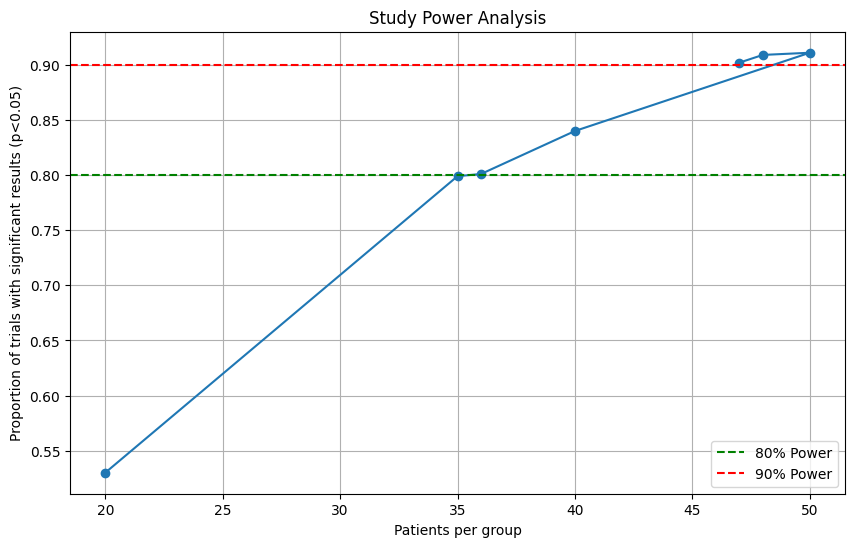

In [126]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(power_df['group size'], power_df['proportion significant'], marker='o')
plt.axhline(y=0.80, color='g', linestyle='--', label='80% Power')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Power')
plt.xlabel('Patients per group')
plt.ylabel('Proportion of trials with significant results (p<0.05)')
plt.title('Study Power Analysis')
plt.legend()
plt.grid(True)
plt.show()